# Mapping natural drains from Contour

STEPS INVOLVED:
1. Convert the contour data to continuous surface raster (DEM).
2. Map the natural drains

### Explore contour data

In [1]:
# create folder to save output
import os
basepath = os.path.join(os.getcwd(), "Output")
os.makedirs(basepath, exist_ok=True)

In [2]:
from osgeo import ogr
Data = "https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/flood-inundation-data/Contour_Lines%2C_Sirmaur%2C_Himachal_Pradesh_8192024.gpkg"

# Open the geopackage
shp = ogr.Open(Data)
layer = shp.GetLayer()

# Print attribute names
layer_definition = layer.GetLayerDefn()
print("Attribute names:")
for i in range(layer_definition.GetFieldCount()):
    field_name = layer_definition.GetFieldDefn(i).GetName()
    print(f"- {field_name}")

# Print attributes of the first few features
print("\nAttributes of the first few features:")
for i, feature in enumerate(layer):
    if i >= 5:  # Limit to the first 5 features
        break
    print(f"\nFeature {i + 1}:")
    for j in range(layer_definition.GetFieldCount()):
        field_name = layer_definition.GetFieldDefn(j).GetName()
        field_value = feature.GetField(field_name)
        print(f"  {field_name}: {field_value}")

# Clean up
layer = None
shp = None


C:\Users\Linda\anaconda3\envs\ugix\Lib\site-packages\osgeo\ogr.py:593: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Attribute names:
- CATEGORY
- SUBCAT
- TYPE
- C_VALUE
- ADL_INFO

Attributes of the first few features:

Feature 1:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 2:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 600.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 3:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 800.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 4:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_

Feature 5:
  CATEGORY: 2
  SUBCAT: 1
  TYPE: 1
  C_VALUE: 1200.0
  ADL_INFO: HYP_Index_Brown_Contour_Reliable_L_


### STEP 1: Prepare continous surface raster from contour line

In [3]:
from osgeo import gdal, ogr, osr
import numpy as np
from scipy.interpolate import griddata

# # Set your input and output paths
# Data has the path to geopackage
output_tif = os.path.join(basepath, "contour_raster.tif")

# Open the geopackage
shp = ogr.Open(Data)
layer = shp.GetLayer()

# Get extent
x_min, x_max, y_min, y_max = layer.GetExtent()

# Create a blank raster
pixel_size = 30  # Adjust this to your desired resolution
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)

target_ds = gdal.GetDriverByName('GTiff').Create(output_tif, x_res, y_res, 1, gdal.GDT_Float32)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

# Set CRS (Coordinate Reference System)
spatial_ref = layer.GetSpatialRef()
target_ds.SetProjection(spatial_ref.ExportToWkt())

# Rasterize the contour lines with C_VALUE as the burn value
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=C_VALUE"]) #the attribute C-VALUE has the elevation information

# Load the rasterized layer into a numpy array
band = target_ds.GetRasterBand(1)
raster_data = band.ReadAsArray()

# Check if raster_data contains any valid values
if np.isnan(raster_data).all():
    raise ValueError("Raster data contains no valid values. Check the contour attribute and input data.")

# Interpolate to create a continuous surface
# Replace zeros with NaN
raster_data = np.where(raster_data == 0, np.nan, raster_data)

# Prepare the interpolation points
x = np.arange(0, raster_data.shape[1])
y = np.arange(0, raster_data.shape[0])
x, y = np.meshgrid(x, y)

# Mask the valid points
points = np.column_stack((x[~np.isnan(raster_data)], y[~np.isnan(raster_data)]))
values = raster_data[~np.isnan(raster_data)]

# Ensure there are valid points for interpolation
if points.size == 0 or values.size == 0:
    raise ValueError("No valid points found for interpolation. Check the rasterization step.")

# Interpolate the surface
'''
-----------------------------------------------------------------------------------
For this exercise cubic interpolation is used.
You can also try  nearest and linear.
source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/ND_unstructured.html
------------------------------------------------------------------------------------
'''
raster_data_interp = griddata(points, values, (x, y), method='cubic')

# Replace NaNs with original values
raster_data_interp[np.isnan(raster_data_interp)] = raster_data[np.isnan(raster_data_interp)]

# Write interpolated data back to the raster
band.WriteArray(raster_data_interp)
band.FlushCache()

# Close the datasets
band = None
target_ds = None

print("Rasterization and interpolation completed successfully!")


Rasterization and interpolation completed successfully!


C:\Users\Linda\anaconda3\envs\ugix\Lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
C:\Users\Linda\anaconda3\envs\ugix\Lib\site-packages\pysheds\io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


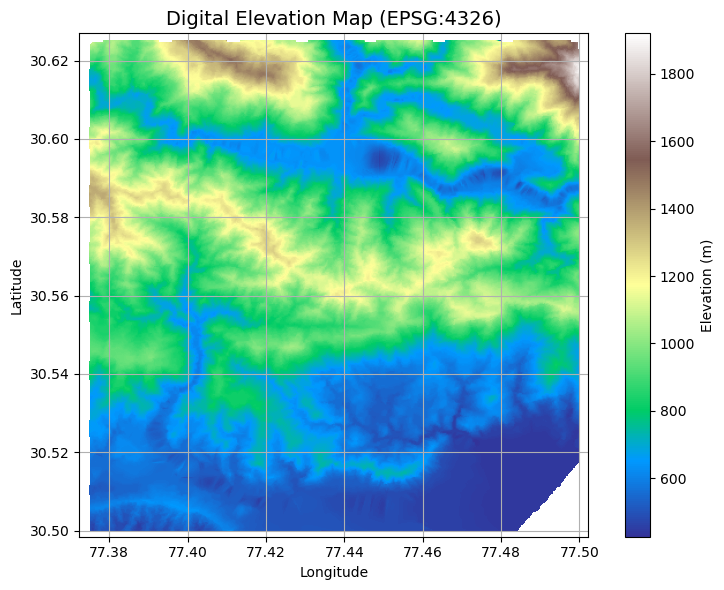

In [5]:
# Import necessary libraries
import rioxarray
import matplotlib.pyplot as plt
import numpy as np

# Read the elevation raster with handling for NoData values
dem_raster = rioxarray.open_rasterio(output_tif, masked=True)  # Mask NoData values automatically

# Reproject the DEM to EPSG:4326 (WGS 84 - Geographic Coordinate System)
dem_raster_4326 = dem_raster.rio.reproject("EPSG:4326")

# Extract the DEM data and check for NoData values
dem_data = dem_raster_4326[0].values  # Extract the DEM data (single band)
dem_data = np.where(dem_data > 1e20, np.nan, dem_data)  # Mask extremely high values (e.g., 1e38)

# Get bounds for plotting
extent = dem_raster_4326.rio.bounds()
extent = [extent[0], extent[2], extent[1], extent[3]]  # (x_min, x_max, y_min, y_max)

# Visualize the DEM raster after reprojection
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

# Display the reprojected DEM with a terrain colormap
im = ax.imshow(dem_data, extent=extent, cmap='terrain', zorder=1)
cbar = plt.colorbar(im, ax=ax, label='Elevation (m)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))  # Format colorbar ticks as integers

# Add title and axis labels
plt.title('Digital Elevation Map (EPSG:4326)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(zorder=0)
plt.tight_layout()

# Show the plot
plt.show()


### STEP 2: Generation of drainage basins

**STEPS INVOLVED:**

    1 Use fill tool to remove noise in DEM generated
    2 Compute flow direction
    3 Generate basin from flow direction and vectorize it
    4 Compute flow accumulation from flow direction
    5 Extract streams from flow accumulation raster using stream network analysis toolset
        (https://www.whiteboxgeo.com/manual/wbt_book/available_tools/stream_network_analysis.html)
    6 Order the streams using Strahler's method
    7 Finally vectorize the stream raster.

In [7]:
'''
Whitebox library is used for stream generation.
Ensure the library is installed. 
If not install using - (https://pypi.org/project/whitebox/)
!pip install whitebox
Read more about hydrological analysis tool in https://www.whiteboxgeo.com/manual/wbt_book/available_tools/hydrological_analysis.html
-------------------------------------------------------------------------------------------------------------------
source code for mapping basins and drains from DEM - 
https://medium.com/@pavlosdemetriades99/1-deployment-of-a-drainage-basin-and-stream-network-using-python-d709d47f05d2
-------------------------------------------------------------------------------------------------------------------
'''


'\nWhitebox library is used for stream generation.\nEnsure the library is installed. \nIf not install using - (https://pypi.org/project/whitebox/)\n!pip install whitebox\nRead more about hydrological analysis tool in https://www.whiteboxgeo.com/manual/wbt_book/available_tools/hydrological_analysis.html\n-------------------------------------------------------------------------------------------------------------------\nsource code for mapping basins and drains from DEM - \nhttps://medium.com/@pavlosdemetriades99/1-deployment-of-a-drainage-basin-and-stream-network-using-python-d709d47f05d2\n-------------------------------------------------------------------------------------------------------------------\n'

In [8]:
# !pip install whitebox
# !pip install leafmap

In [9]:
# Importing libraries
import os
import whitebox 
import leafmap
import leafmap.foliumap
wbt = whitebox.WhiteboxTools()

In [10]:
# Define the working environment (path) which the DEM is located
# Here the same folder containing data (basepath) is used to write output too
wbt.set_working_dir(basepath)

___________________________________________________________________________________________________________________________________________
***DEM generated is preprocessed to remove noise using "breach depressions". It fill all of the depressions in a digital elevation model (DEM) and to remove the flat areas. This is a common pre-processing step required by many flow-path analysis tools to ensure continuous flow from each grid cell to an outlet located along the grid edge. There are alternate tools to perform same presented in the whitebox manual, which can also be tried.***
___________________________________________________________________________________________________________________________________________

In [11]:
# 1. Breach depressions of Digital Elevation Model (DEM)
wbt.breach_depressions(dem = "contour_raster.tif", output = "DEM_BreachDepression.tif")

.\whitebox_tools.exe --run="BreachDepressions" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --dem='contour_raster.tif' --output='DEM_BreachDepression.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress

0

In [12]:
# 2. Calculation of flow Direction using d8_pointer
wbt.d8_pointer(dem = "DEM_BreachDepression.tif", output = "D8_Pointer_python.tif")

.\whitebox_tools.exe --run="D8Pointer" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --dem='DEM_BreachDepression.tif' --output='D8_Pointer_python.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progr

0

In [13]:
# 3. Calculation of Basin
wbt.basins(d8_pntr='D8_Pointer_python.tif', output = "Basins_python.tif")

# 4. RasterToVectorPolygon
wbt.raster_to_vector_polygons(i = "Basins_python.tif",output="Basins_python_Shapefile.shp")

.\whitebox_tools.exe --run="Basins" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --d8_pntr='D8_Pointer_python.tif' --output='Basins_python.tif' -v --compress_rasters=False

****************************
* Welcome to Basins        *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initializing: 18%
Initializing: 19%
Initializing: 20%
Initializing: 21%
Initializing: 22%
Initializing: 23%
Initializing: 24%
Initializing: 25%
Initializing: 26%
Initializing: 27%
Initializing: 28%
Initializing: 29%
Initializing: 30%
Initializing: 31%
Initializing: 32%
Initializing: 33%
Initializing: 34%
Initializin

0

In [14]:
# Visualization of all raster layers (.tif)

# Calling leafmap.Map() function for the visualization of Map
m = leafmap.Map()

# Add a raster layer

m.add_raster(os.path.join(basepath,"contour_raster.tif"), colormap="terrain", layer_name="DEM")
m.add_raster(os.path.join(basepath,"DEM_BreachDepression.tif"), colormap="terrain", layer_name="Corrected DEM")
# Likewise you can apply various color range using colormap parameter. 
# colormap options - https://leafmap.org/notebooks/23_colormaps/
m.add_raster(os.path.join(basepath,"D8_Pointer_python.tif"), layer_name="Flow direction")
m.add_raster(os.path.join(basepath,"Basins_python.tif"), layer_name="Basins")

# Display the map
m

Map(center=[30.562629, 77.437306], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

###  STEP 3: Generation of stream network

**STEPS INVOLVED:**

    1. Compute flow accumulation using flow direction raster. Flow accumulation denotes how much water is accumulated in a particular cell from the upstream cells. For example if the value of flow accumulation is 3, then the cell gets water from 3 upstream cells.
    2. Generate stream network by specifying threshold.
    3. Finally vectorize the raster streams 

In [15]:
# 1. Calculation of Flow Accumulation
wbt.d8_flow_accumulation(i='D8_Pointer_python.tif',output="D8_Flow_Accumulation_Python.tif",log=True,pntr=True)

.\whitebox_tools.exe --run="D8FlowAccumulation" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --input='D8_Pointer_python.tif' --output='D8_Flow_Accumulation_Python.tif' --out_type=cells --log --pntr -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
Flow directions: 0%
Flow directions: 1%
Flow directions: 2%
Flow directions: 3%
Flow directions: 4%
Flow directions: 5%
Flow directions: 6%
Flow directions: 7%
Flow directions: 8%
Flow directions: 9%
Flow directions: 10%
Flow directions: 11%
Flow directions: 12%
Flow directions: 13%
Flow directions: 14%
Flow directions: 15%
Flow directions: 16%
Flow directions: 17%
Flow directions: 18%
Flow directions: 19%
Flow directions: 20%
Flow directions: 21%
Flow directions: 22%
Flow directions: 23%
Flow directions: 24%
Flow directions: 25%
Flow directions:

0

___________________________________________________________________________________________________________________________________________
***Streams are generated from flow accumulation raster by specifying a threshold value. The threshold value in the wbt.extract_streams function represents the minimum flow accumulation value that a cell must have to be considered part of the stream network. It acts as a cutoff value. Only those cells where the flow accumulation is equal to or greater than this threshold value will be included in the extracted stream network.***

***For example, if you set the threshold to 4, only cells with a flow accumulation value of 4 or more will be classified as part of the stream network. Lowering the threshold will result in more cells being classified as streams (potentially identifying smaller streams), while increasing the threshold will result in fewer cells being classified as streams (focusing on larger streams).***
___________________________________________________________________________________________________________________________________________

In [16]:
# 2. Deployment of Stream Network
# Threshold value selected after different options of its value
wbt.extract_streams(flow_accum="D8_Flow_Accumulation_Python.tif",output="Stream_Network_python.tif",threshold=4)

.\whitebox_tools.exe --run="ExtractStreams" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --flow_accum='D8_Flow_Accumulation_Python.tif' --output='Stream_Network_python.tif' --threshold='4' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Pro

0

___________________________________________________________________________________________________________________________________________
***Stream ordering is a method used to classify streams by size, ranging from first-order streams, which are the smallest, to the largest, 12th-order streams. 
A first-order stream is the smallest type, made up of small tributaries that feed into larger streams but typically do not receive water from other streams. First- and second-order streams often form on steep slopes and flow rapidly until they join a higher-order waterway.***

***Streams of the first to third order are known as headwater streams, found in the upper parts of a watershed. These headwater streams make up over 80% of the world’s waterways. As streams increase in size and strength, those classified as fourth- through sixth-order are considered medium streams, while anything larger, up to 12th-order, is classified as a river. Unlike smaller streams, medium and large rivers generally have gentler slopes and flow more slowly, but they carry larger amounts of runoff and debris, as they collect water from the smaller streams feeding into them.***

***Stream order is also used in geographic information systems (GIS) to map river networks. It aids biogeographers and biologists in determining the types of life that might inhabit different waterways. Whether used by GIS specialists, biogeographers, or hydrologists, stream order is a valuable tool for classifying the world’s waterways and is essential for understanding and managing the differences between streams of varying sizes.***

***The whitebox tool has several methods to map stream orders (https://www.whiteboxgeo.com/manual/wbt_book/available_tools/stream_network_analysis.html). For this exercise, Strahler's method is used.***
___________________________________________________________________________________________________________________________________________

In [17]:
# 3. Ordering the stream order by Strahler Order
wbt.strahler_stream_order(d8_pntr="D8_Pointer_python.tif",streams="Stream_Network_python.tif",output="Strahler_Stream_Order_python.tif",zero_background=True)

.\whitebox_tools.exe --run="StrahlerStreamOrder" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --d8_pntr='D8_Pointer_python.tif' --streams='Stream_Network_python.tif' --output='Strahler_Stream_Order_python.tif' --zero_background -v --compress_rasters=False

**********************************
* Welcome to StrahlerStreamOrder *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading pointer data...
Reading streams data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progr

0

In [18]:
# 4. Vectorization of Strahler Order Stream Network 
wbt.raster_to_vector_lines(i="Strahler_Stream_Order_python.tif",output="Strahler_Stream_Order_python.shp")

.\whitebox_tools.exe --run="RasterToVectorLines" --wd="C:\LINDA_UGIX\UGI- SANDBOXES\final\Mapping drainage network_Sirmaur\Data" --input='Strahler_Stream_Order_python.tif' --output='Strahler_Stream_Order_python.shp' -v --compress_rasters=False

**********************************
* Welcome to RasterToVectorLines *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%


0

### Visualization of all output

In [19]:
import os
import geopandas as gpd
import leafmap
import json

# Define the path to your shapefile
shapefile_path = os.path.join(basepath, "Strahler_Stream_Order_python.shp")

# Load the shapefile with GeoPandas
gdf = gpd.read_file(shapefile_path)

# Ensure the CRS is WGS84 (EPSG:4326)
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Convert GeoDataFrame to GeoJSON format
geojson_data = gdf.to_json()

# Write the GeoJSON data to a temporary file
geojson_path = os.path.join(basepath, "temp_stream_order.geojson")
with open(geojson_path, 'w') as f:
    f.write(geojson_data)

# Initialize the map
m = leafmap.Map(center=(gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()), zoom=10)

# Define the style function
def style_function(feature):
    # Get the stream order from the feature properties
    stream_order = feature['properties'].get('VALUE', 1)  # Default to 1 if 'VALUE' is missing
    return {
        'color': 'blue',
        'weight': stream_order  # Use the stream order value for weight
    }

# Add the GeoJSON layer to the map with the style function
m.add_geojson(
    geojson_path,
    layer_name="Stream Order",
    style_callback=style_function  # Use style_callback instead of style
)

# Add Layer Control
m.add_layer_control()

# Add raster layers
m.add_raster(os.path.join(basepath,"contour_raster.tif"), colormap="terrain", layer_name="DEM")
m.add_raster(os.path.join(basepath,"DEM_BreachDepression.tif"), colormap="terrain", layer_name="Corrected DEM")
# Likewise you can apply various color range using colormap parameter. 
# colormap options - https://leafmap.org/notebooks/23_colormaps/
m.add_raster(os.path.join(basepath,"D8_Pointer_python.tif"), layer_name="Flow direction")
m.add_raster(os.path.join(basepath,"Basins_python.tif"), layer_name="Basins")
m.add_raster(os.path.join(basepath, "D8_Flow_Accumulation_Python.tif"), layer_name="Flow_Accumulation")
m.add_raster(os.path.join(basepath, "Strahler_Stream_Order_python.tif"), layer_name="Strahler_Stream_Order_python.tif", palette="Blues")

# Save the map as an HTML file
m.save(os.path.join(basepath, "map_with_shapefile.html"))

# Display the map (this might not display directly in non-notebook environments)
m


Map(center=[30.562629, 77.437306], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…